# Draw Figure 1

Figure 1. MCS days for (a) HIST, (b) EoC 4.5, and (d) EoC 8.5, and changes in mean annual MCS day counts relative to HIST for (c) EoC 4.5 and (e) EoC 8.5. Analysis subregions in panel (a) include: (i) Northern Plains, (ii) Southern Plains, (iii) Midwest, (iv) Southeast, (v) Northeast, and (i-v) ECONUS. 

# Organize the data into annual sums, annual means, and differences

In [1]:
import xarray as xr

data_dir = "../data"
analysis='mcs_days'
subset='monthly'

simulation_names = {'historical': 'HIST', 
                    'future_4p5': 'EoC 4.5', 
                    'delta_future_4p5': '$\Delta$ EoC 4.5',
                    'future_8p5': 'EoC 8.5', 
                    'delta_future_8p5': '$\Delta$ EoC 8.5'}
    
annual_years = {}
annual_means = {}

pref = "../data"

for sim in simulation_names.keys():

    annual_years[sim] = {}
    annual_means[sim] = {}
    
    if sim in ['historical', 'future_4p5', 'future_8p5']:
        
        ds = xr.open_mfdataset(f"{data_dir}/{analysis}/{sim}_{subset}/*.nc")
        ds = ds.resample(time='AS-OCT').sum('time')
        ds = ds.compute()

        ds_mean = ds.mean('time')
        ds_mean = ds_mean.compute()

        annual_years[sim] = ds
        annual_means[sim] = ds_mean
        
    else:

        futr_str = sim.replace("delta_", "")
        
        annual_means[sim] = annual_means[futr_str] - annual_means['historical']
        annual_years[sim] = None

# Draw map and results

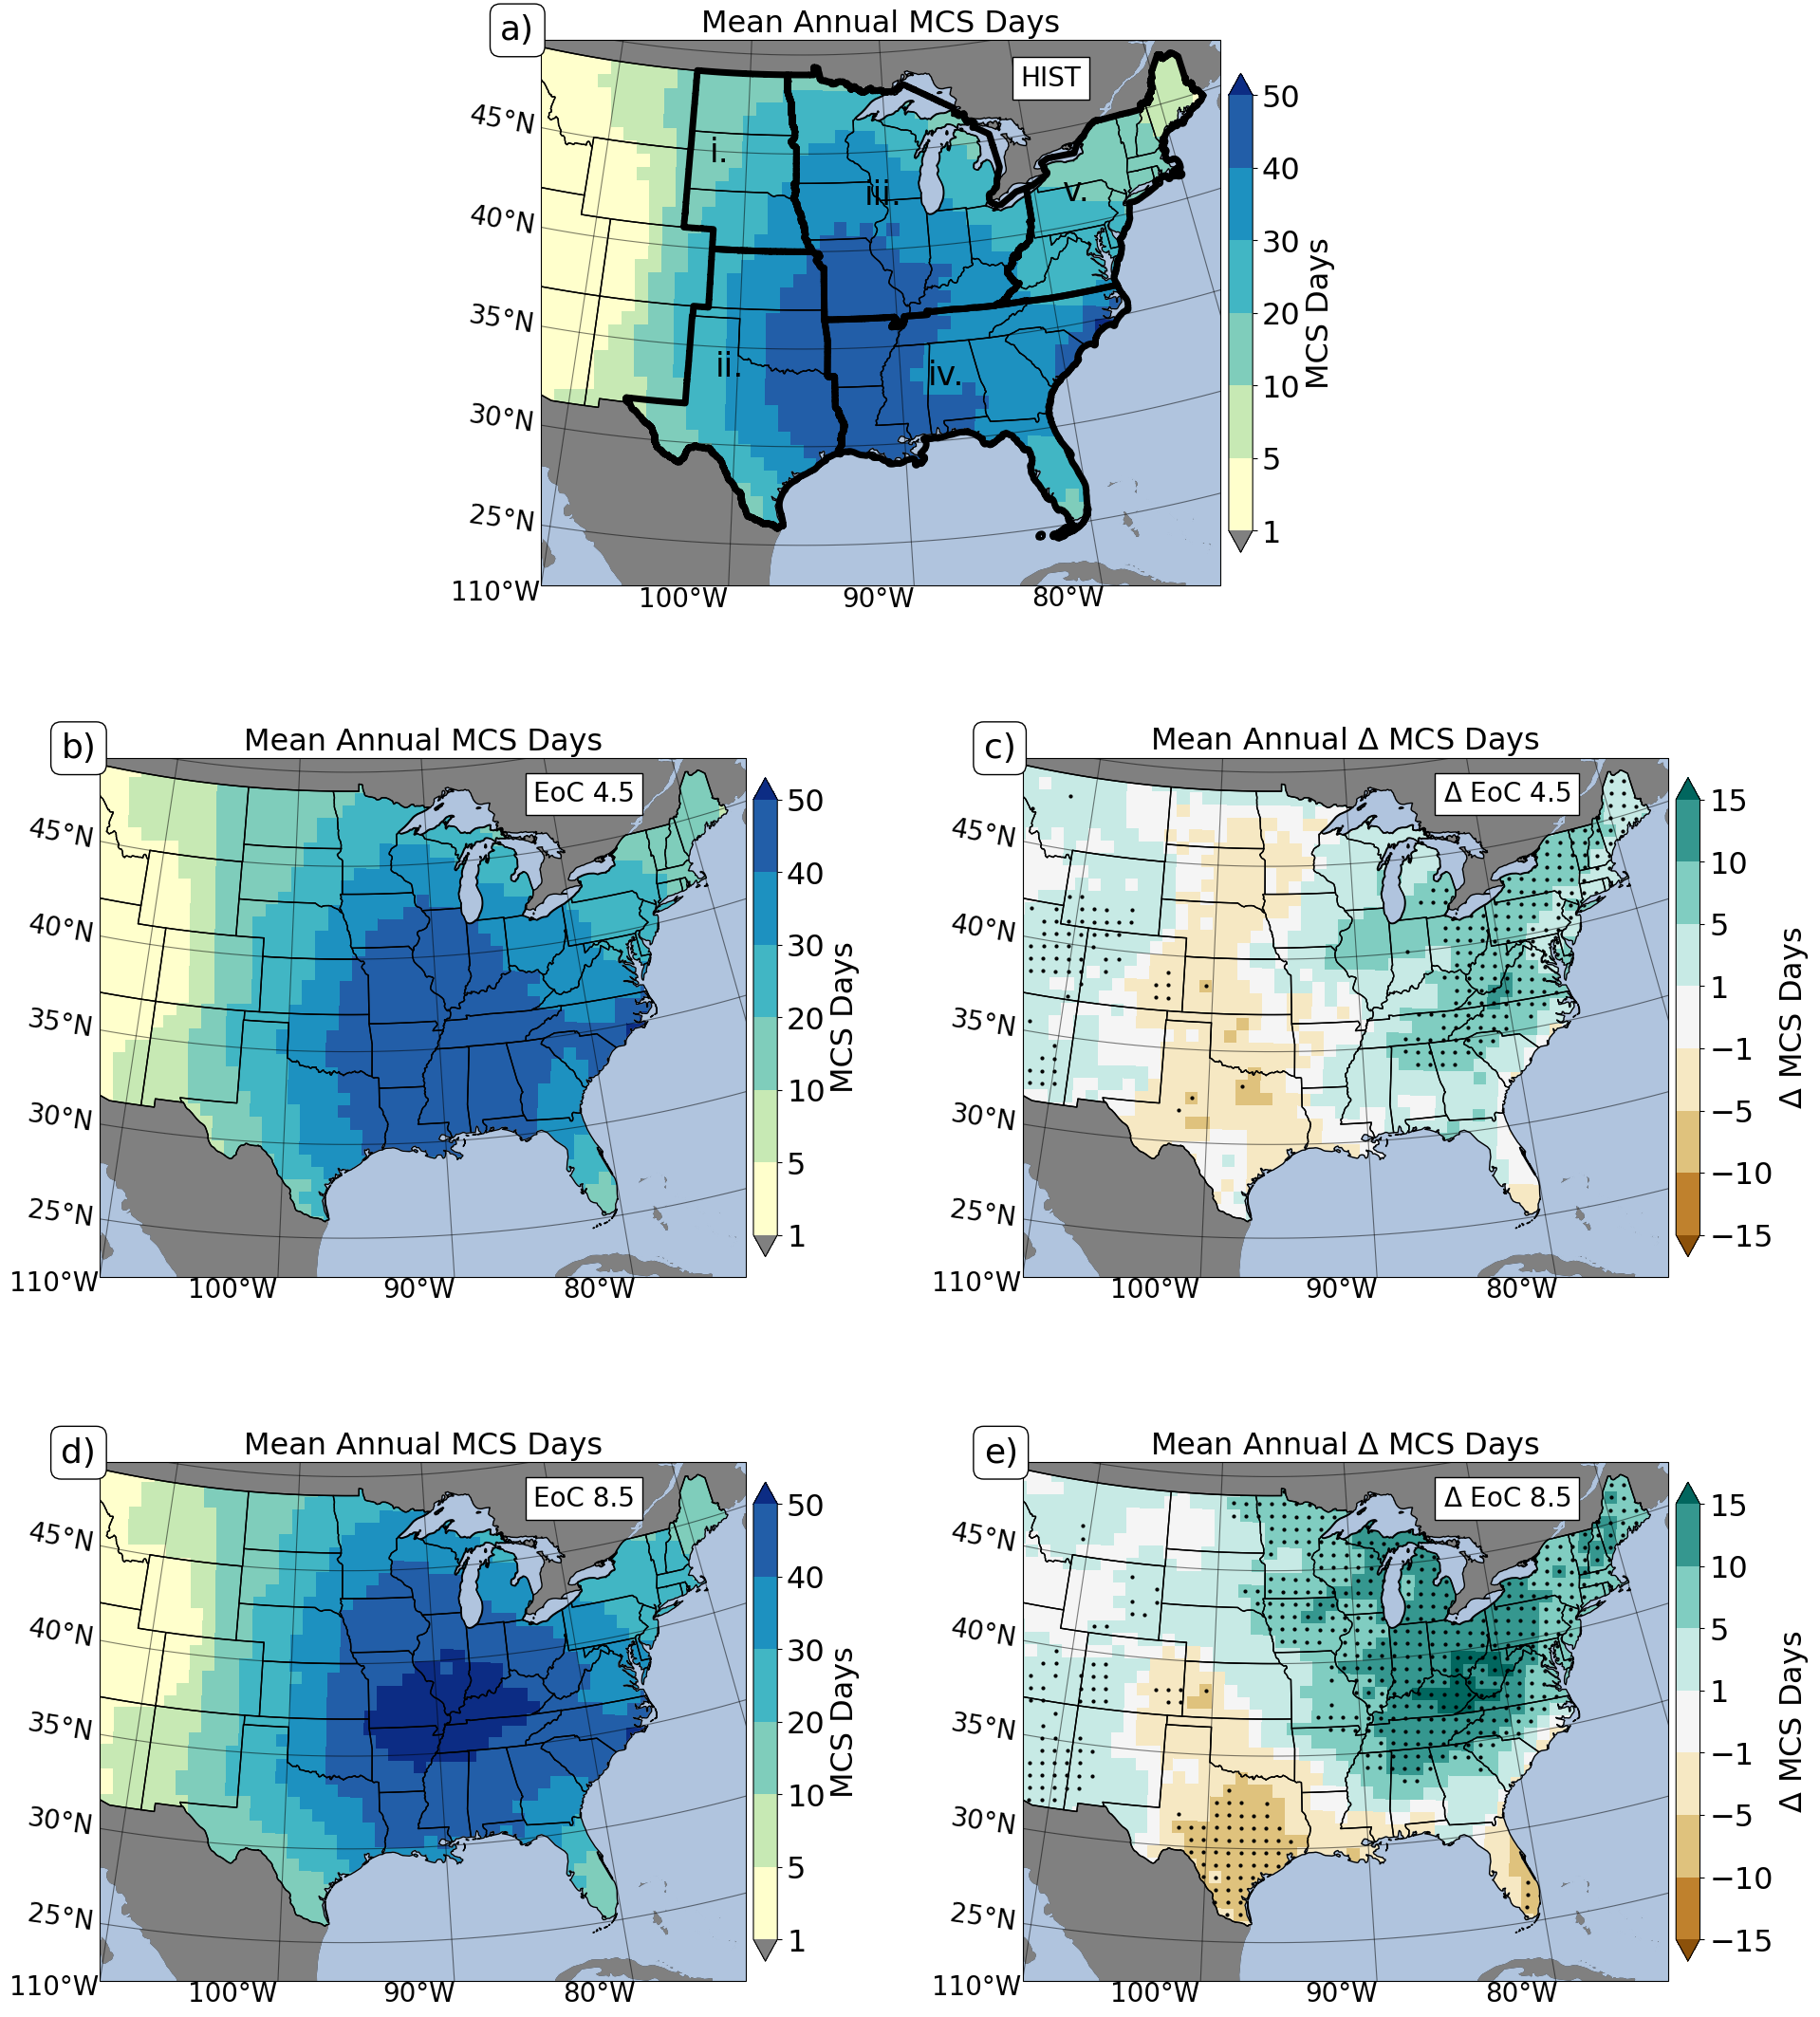

In [2]:
from mapping import setup_map, spec_ax, get_color_dict
from stats import grid_significance
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['xtick.labelsize'] = 23
plt.rcParams['ytick.labelsize'] = 23
plt.rcParams['axes.titlesize'] = 23
plt.rcParams['axes.labelsize'] = 23

color_info = get_color_dict(1)

fig = plt.figure(figsize=(23, 27))

for ax_pos, (sim_name, sim_abbr) in enumerate(simulation_names.items()):

    ax = spec_ax(ax_pos, nrows=3, ncols=4, fig=fig, five_panel=True)

    ax = setup_map(label_num=ax_pos+1, ax=ax, draw_outlines=True)
    
    ax.annotate(f"{sim_abbr}", (0.75,0.93), 
                xycoords='axes fraction', ha='center', va='center',
                fontsize=20, bbox=dict(boxstyle='square', facecolor='w', alpha=1), 
                color='k', zorder=25)

    mmp = ax.pcolormesh(annual_means[sim_name].lon, annual_means[sim_name].lat, 
                        annual_means[sim_name]['MCS_Days'],
                        transform=ccrs.PlateCarree(), 
                        cmap=color_info[sim_name]['cmap'], norm=color_info[sim_name]['norm'], zorder=5)

    cbar = plt.colorbar(mmp, ax=ax, shrink=0.85, extend='both', pad=0.01)
    
    if sim_name in ['historical', 'future_4p5', 'future_8p5']:

        ax.set_title("Mean Annual MCS Days")
        
        cbar.set_label(label="MCS Days")

    else:
        
        futr_str = sim_name.replace("delta_", "")
        
        ax.set_title("Mean Annual $\Delta$ MCS Days")
        
        cbar.set_label(label="$\Delta$ MCS Days")
        
        sig = grid_significance(annual_years['historical']['MCS_Days'].values, 
                                annual_years[futr_str]['MCS_Days'].values)

        pts_sig = np.where(sig < 0.05)

        ax.plot(annual_means['historical'].lon.values[pts_sig],
                annual_means['historical'].lat.values[pts_sig],
                transform=ccrs.PlateCarree(), zorder=5, linestyle='None', 
                marker='.', color='k', ms=4)
        
    ax.spines['geo'].set_zorder(24)
    
plt.savefig("Figure_1.png", dpi=200, bbox_inches='tight')